<h1><center><img src="https://upload.wikimedia.org/wikipedia/fr/thumb/c/c6/Grenoble_INP_-_Ense3_%28logo%29.svg/2560px-Grenoble_INP_-_Ense3_%28logo%29.svg.png" style="width:342px;height:131px"/></center><h1>

---

__<h2><center> Smart Energy Building <center><h2>__
    -*Guided by Christian Ghiaus*

---
    
__<center> GIANNOTTI Sophie - BIALKOWSKI Victor - BANZET Ambre - LASSOUED Firas <center>__
    
---
    
# Introduction
    
Building Energy Management is physics-based software simulation of building energy use. A BEM program takes as input a description of a building including geometry, construction materials, lighting, HVAC, refrigeration, water heating and many more. For further accuracy BEM can take into account further inputs like the description of the building’s use and operation including schedules for occupancy, lighting, plug-loads, and thermostat settings. A BEM program combines these inputs with information about local weather and uses physics equations to calculate thermal loads, system response to those loads, and resulting energy use, along with related metrics like occupant comfort and energy costs. 
The objective of this study is to implement a BEM program for a room we designed with the relevant inputs and discuss the results obtained.
    
The following hypotheses were followed:
    
- <div style="text-align: left">Uniform surface temperature on each wall or part of wall.
- <div style="text-align: left">One-dimensional heat transfer in each wall or part of wall.
- <div style="text-align: left">Diffuse distribution of solar radiation within rooms.
- <div style="text-align: left">The LW radiation exchange between outer surfaces and the ground is neglected.
- <div style="text-align: left">All heat transfer treated as linear phenomena. 
    
    
---

# Room Design    

We were given free reigns over the design of the room, here is a sketch of what we ultimately ended up choosing :
    
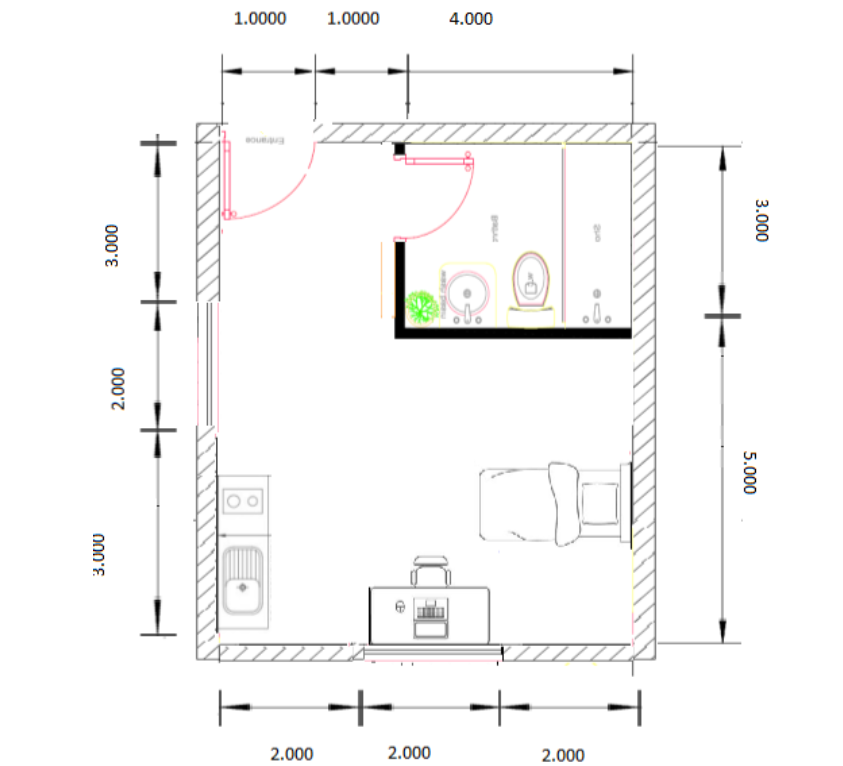



Here are a few details about the building construction:
    
- <div style="text-align: left">The building is composed of one main area which contains a deskspace, a kitchen and a bed. </div>
- <div style="text-align: left">A bathroom is placed in the corner, the bathroom walls are clad with ceramic tiles on the inside. </div>
- <div style="text-align: left">The walls are insulated with paint and made out of concrete. </div>
    
---

# <div style="text-align: left">Thermal Model</div>

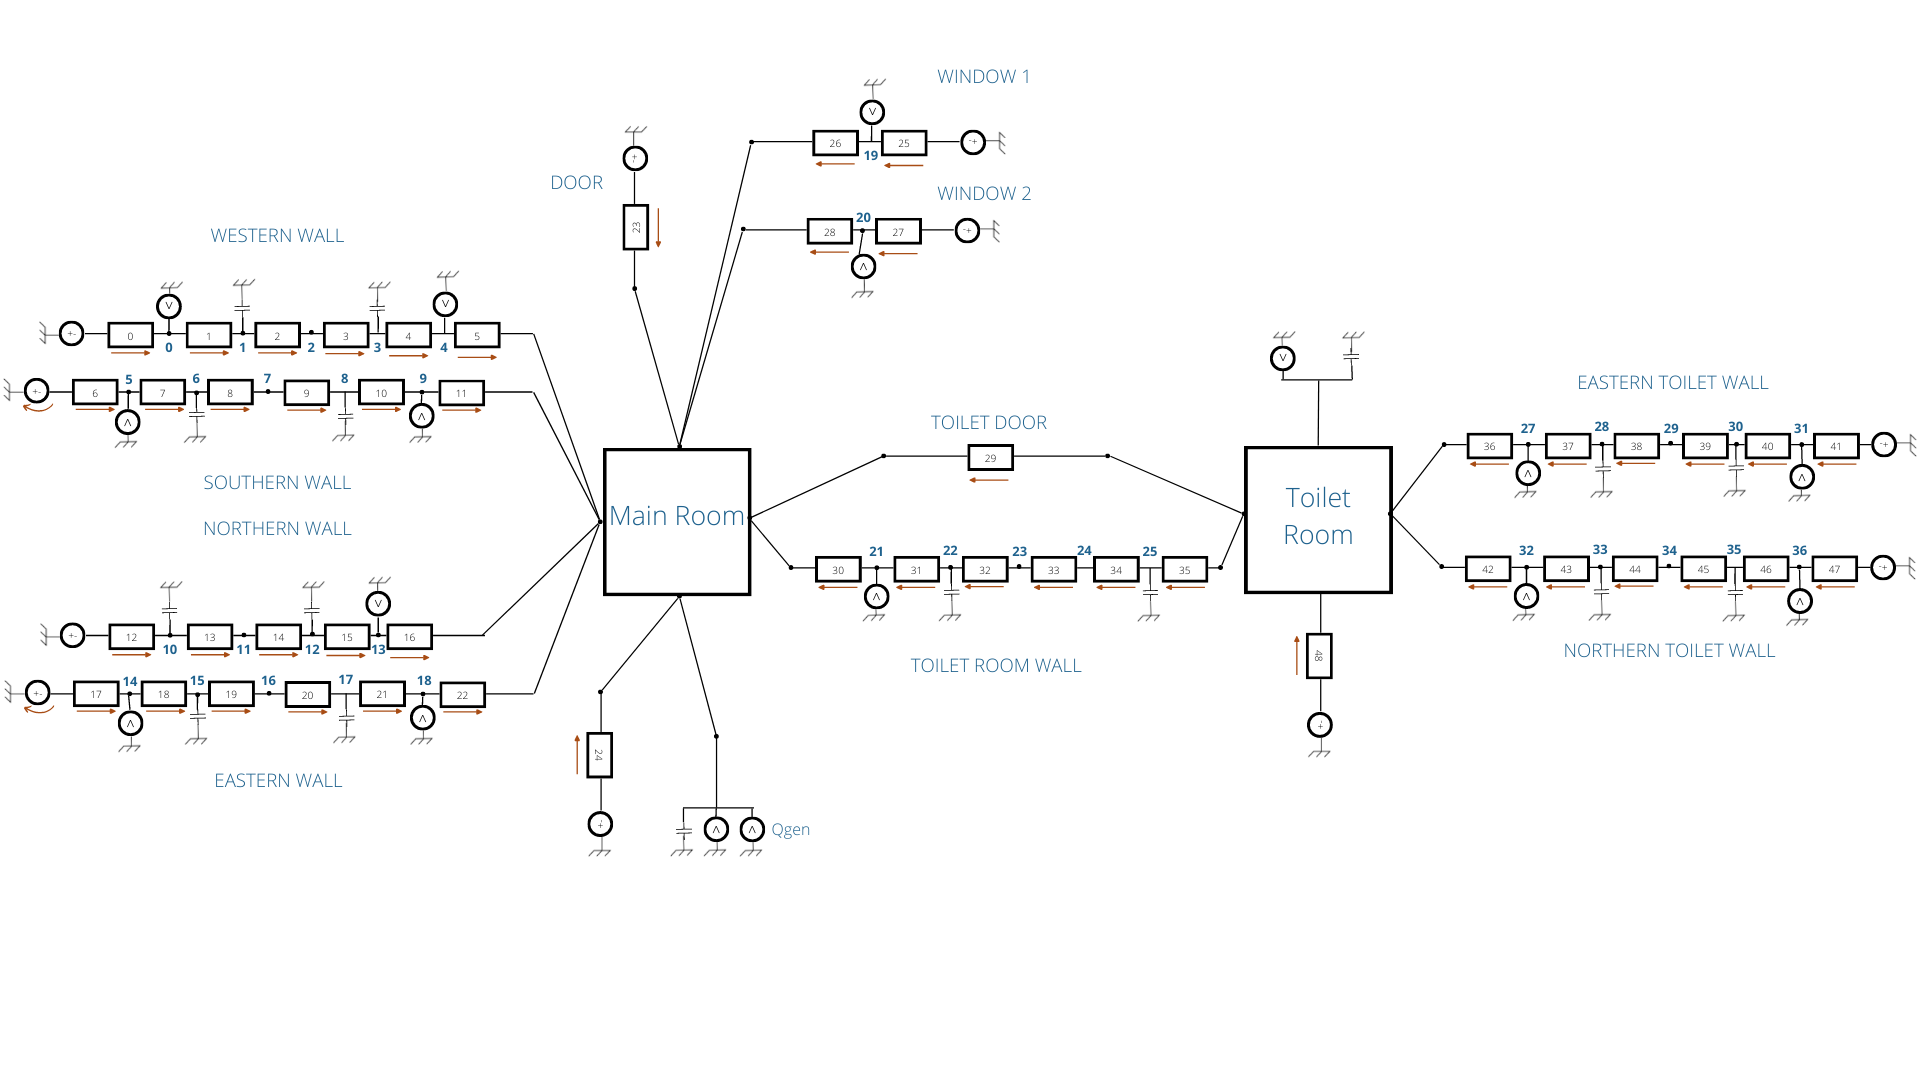


Each node and resistance are used in the matrices of the thermal equation $Cθ=-A^T GAθ+A^T Gb+f$.

- The A-matrix has a number of lines equal to the number of flows and a number of columns equal to the number of nodes. It defines how a flow is connected to nodes. If the path is aligned with the heat flow, then the corresponding coefficient in the A-matrix is 1. If the flow is in the opposite direction, the coefficient is -1.

- G represents the resistances of each surface, while C represents the capacity of the walls.

- The f and b matrices represents the constraints imposed on the model. The f matrix represents the different sources whereas the b matrix represents the places where there is an exterior temperature.










    
    
    
    
    
    
    
    
    
    

    

    
    

    

    
    
    
    

The heat resistances are calculated with these formulae:

$$R_{cd} = \frac{w}{\lambda S}$$
where:

- $w$ is the width of the material, m;
- $\lambda$ - thermal conductvity, W/m K;
- $S$ - surface area of the wall, m²

The thermals resistance for convection are of the form:
$$R_{cv} = \frac{1}{h S}$$
where:
- $h$ is the convection coefficient, W/m² K;
- $S$ - surface area of the wall, m².


---

The following code is used to define the G, C, A and b matrices:

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

Kp = 1e4    

S_wall_W=6*3
S_wall_S=2*2*3
S_wall_E=5*3
S_wall_N=1*3

S_door=1*3

S_window_1=2*3
S_window_2=2*3

S_toilet_door=1*3
S_toilet_room_wall=3*(2+4)

S_toilet_wall_E=3*3
S_toilet_wall_N=4*3

S_c=S_wall_W+S_wall_S+S_wall_E+S_wall_N+S_toilet_wall_E+S_toilet_wall_N
S_g=S_window_1+S_window_2

wall = {'lambda': [1.4, 3e-2, 1.2],  
        'rho*c': [2000000, 26000, 1000000],        
        'w': [0.15, 0.08, 0.02] }
        
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass'])

hout=20
hin=4

rho_air=.2                      # kg/m³
c_air=1000               # J/kg.K

Va = (6*8)*3          # m³ volume of air
ACH = 1             # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration
#matriceG


ε_wLW = 0.9     # long wave wall emmisivity (concrete)
α_wSW = 0.2     # absortivity white surface
ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83    # short wave glass transmitance (glass)
α_gSW = 0.1     # short wave glass absortivity

σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant

Fwg = 1 / 5     # view factor wall - glass

Tm = 20 + 273   # mean temp for radiative exchange

GLW1 = ε_wLW / (1 - ε_wLW) * (S_wall_W+S_wall_S+S_wall_E+S_wall_N+S_toilet_wall_E+S_toilet_wall_N) * 4 * σ * Tm**3
GLW2 = Fwg * (S_wall_W+S_wall_S+S_wall_E+S_wall_N+S_toilet_wall_E+S_toilet_wall_N) * 4 * σ * Tm**3
GLW3 = ε_gLW / (1 - ε_gLW) * (S_wall_W+S_wall_S+S_wall_E+S_wall_N+S_toilet_wall_E+S_toilet_wall_N)* 4 * σ * Tm**3
# long-wave exg. wall-glass
GLW = 1 / (1 / GLW1 + 1 / GLW2 + 1 / GLW3)

Gv = Va_dot * rho_air * c_air


g=np.zeros(49)
g[0]=hout*S_wall_W
g[1]=wall['lambda'][0]/wall['w'][0]*S_wall_W
g[2]=g[1]
g[3]=wall['lambda'][1]/wall['w'][1]*S_wall_W
g[4]=g[3]
g[5]=hin*S_wall_W

g[6]=hout*S_wall_S
g[7]=wall['lambda'][0]/wall['w'][0]*S_wall_S
g[8]=g[7]
g[9]=wall['lambda'][1]/wall['w'][1]*S_wall_S
g[10]=g[9]
g[11]=hin*S_wall_S

g[12]=hin*S_wall_W
g[13]=g[12]
g[14]=wall['lambda'][1]/wall['w'][1]*S_wall_N
g[15]=g[14]
g[16]=hin*S_wall_W

g[17]=hout*S_wall_E
g[18]=wall['lambda'][0]/wall['w'][0]*S_wall_E
g[19]=g[18]
g[20]=wall['lambda'][1]/wall['w'][1]*S_wall_E
g[21]=g[20]
g[22]=hin*S_wall_E

g[23]=S_door*hout

g[24]=2 #VALEUR A COMPLETER 

g[25]=hout*S_window_1
g[26]=hin*S_window_1

g[27]=hout*S_window_2
g[28]=hin*S_window_2

g[29]=S_toilet_door*hin

g[30]=hin*S_toilet_room_wall
g[31]=(wall['lambda'][0]/wall['w'][0])*S_toilet_room_wall
g[32]=g[31]
g[33]=(wall['lambda'][0]/wall['w'][0])*S_toilet_room_wall
g[34]=g[33]
g[35]=hin*S_toilet_room_wall

g[36]=hin*S_toilet_wall_E
g[37]=(wall['lambda'][1]/wall['w'][1])*S_toilet_wall_E
g[38]=g[37]
g[39]=(wall['lambda'][0]/wall['w'][0])*S_toilet_wall_E
g[40]=g[39]
g[41]=hout*S_toilet_wall_E

g[42]=hin*S_toilet_wall_N
g[43]=(wall['lambda'][1]/wall['w'][1])*S_toilet_wall_N
g[44]=g[43]
g[45]=(wall['lambda'][0]/wall['w'][0])*S_toilet_wall_N
g[46]=g[45]
g[47]=hout*S_toilet_wall_N

g[48]=GLW+Gv


G=np.diag(g)

#matrice C 


c=np.zeros(39)
c[1]=S_wall_W*wall['w'][1]*wall['rho*c'][1]
c[3]=S_wall_W*wall['w'][0]*wall['rho*c'][0]
c[6]=S_wall_S*wall['w'][1]*wall['rho*c'][1]
c[8]=S_wall_S*wall['w'][0]*wall['rho*c'][0]
c[10]=S_wall_N*wall['w'][1]*wall['rho*c'][1]
c[12]=S_wall_N*wall['w'][0]*wall['rho*c'][0]
c[15]=S_wall_E*wall['w'][1]*wall['rho*c'][1]
c[17]=S_wall_E*wall['w'][0]*wall['rho*c'][0]
c[22]=S_toilet_room_wall*wall['w'][0]*wall['rho*c'][0]
c[25]=S_toilet_room_wall*wall['w'][0]*wall['rho*c'][0]
c[28]=S_toilet_wall_E*wall['w'][0]*wall['rho*c'][0]
#c[29]=S_toilet_wall_E*wall['w'][1]*wall['rho*c'][1]
c[33]=S_toilet_wall_N*wall['w'][0]*wall['rho*c'][0]
#c[35]=S_toilet_wall_N*wall['w'][1]*wall['rho*c'][1]
c[37]=50000   
c[38]=50000   


C=np.diag(c)


#matrice A
A=np.zeros((49,39))

A[ 0, 0]=1
A[ 1, 0] = - 1
A[ 1, 1] = 1
A[ 2, 1] = - 1
A[ 2, 2] = 1
A[ 3, 2] = - 1 
A[ 3, 3] = 1
A[ 4, 3] = - 1
A[ 4, 4] = 1
A[ 5, 38] = 1


A[ 6, 5] = 1
A[ 7, 5] = - 1
A[ 7, 6] = 1
A[ 8, 6] = - 1
A[ 8, 7] = 1
A[ 9, 7] = - 1
A[ 9, 8] = 1
A[ 10, 8] = - 1
A[ 10, 9] = 1
A[ 11, 9] = - 1
A[ 11, 38] = 1


A[ 12, 10] = 1
A[ 13, 10] = - 1
A[ 13, 11] = 1 
A[ 14, 11] = - 1
A[ 14, 12] = 1
A[ 15, 12] = - 1
A[ 15, 13] = 1 
A[ 16, 13] = - 1
A[ 16, 38] = 1


A[ 17, 14] = 1
A[ 18, 14] = - 1
A[ 18, 15] = 1
A[ 19, 15] = - 1
A[ 19, 16] = 1
A[ 20, 16] = - 1
A[ 20, 17] = 1
A[ 21, 17] = - 1
A[ 21, 18] = 1
A[ 22, 18] = - 1
A[ 22, 38] = 1


A[ 23, 38] = 1


A[ 24, 38] = 1


A[ 25, 19] = 1
A[ 26, 19] = - 1 
A[ 26, ] = 1


A[ 27, 20] = 1 
A[ 28, 20] = - 1
A[ 28, 38] = 1


A[ 29, 37] = - 1
A[ 29, 38] = 1


A[ 30, 38] = 1
A[ 30, 21] = - 1
A[ 31, 21] = 1 
A[ 31, 22] = - 1
A[ 32, 22] = 1
A[ 32, 23] = - 1
A[ 33, 23] = 1
A[ 33, 24] = - 1
A[ 34, 24] = 1 
A[ 34, 25] = - 1
A[ 35, 25] = 1 
A[ 35, 37] = - 1


A[ 48, 37] = - 1 


A[ 36, 37] = 1
A[ 36, 27] = - 1
A[ 37, 27] = 1 
A[ 37, 28] = - 1
A[ 38, 28] = 1 
A[ 38, 29] = - 1
A[ 39, 29] = 1 
A[ 39, 30] = - 1
A[ 40, 30] = 1 
A[ 40, 31] = - 1
A[ 41, 31] = 1 


A[ 42, 37] = 1
A[ 42, 32] = - 1 
A[ 43, 32] = 1
A[ 43, 33] = - 1 
A[ 44, 33] = 1
A[ 44, 34] = - 1 
A[ 45, 34] = 1
A[ 45, 35] = - 1
A[ 46, 35] = 1
A[ 46, 36] = - 1
A[ 47, 36] = 1

#vecteur b

b=np.zeros((49,1))
b[0]=20
b[6]=20
b[12]=20
b[17]=20
b[23]=20
b[24]=20
b[25]=20
b[27]=20
b[41]=20
b[43]=20

The thermal capacities of the wall and air are of this form:


$C_{wall}= \rho_{wall} c_{p, wall} w_{wall} S_{wall}$


$C_{air} = \rho_{air} c_{air} V_{air}$

---
# State-space model

The state-space representation of the dynamic model is obtained from the differential-algebraic set of equations:

In [ ]:
#state-space model

ytc = np.linalg.inv((A.transpose()).dot(G).dot(A)).dot((A.transpose()).dot(G).dot(b)+ f)

#steady state

b=np.zeros(49)
b[[0, 5, 12, 17, 23, 24, 25, 27, 41, 47, 48]] = 10 + np.array([0, 50, 120, 170, 230, 240, 250, 270, 410, 470, 480])
f = np.zeros(39)
f[[0, 4, 5, 9, 13, 14, 18, 19, 20, 21, 27, 31, 32, 36, 37, 38]] = 100 + np.array([0, 400, 500, 900, 1300, 1400, 1800, 1900, 2000, 2100, 2700, 3100, 3200, 3600, 3700, 3800])
y = np.ones(39)


ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

#state-space and steady state comparison

yss = (-Cs.dot(np.linalg.inv(As)).dot(Bs) + Ds).dot( u)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

---

# Dynamic simulation


The inputs vary in time (since the simulation is dynamic). The sources in our thermal model are represented by a value of one:

In [7]:


b=np.zeros(49)
b[[0, 5, 12, 17, 23, 24, 25, 27, 41, 47, 48]] =1
f = np.zeros(39)
f[[0, 4, 5, 9, 13, 14, 18, 19, 20, 21, 27, 31, 32, 36, 37, 38]]=1

y=np.zeros(39)
y[[38]]=1

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

---

# Time-Step

The maximum time step for numerical stability of Euler explicit itegration in time is given by the minimum value $\lambda$ of the state matrix $A_s$: 

$\Delta t \leq \min (-2 / \lambda_i) = \min T_i/2$

where 

$T_i$ is the time constant, $T_i = - \frac{1}{\lambda_i} $

Maximum time step: 170.71 s


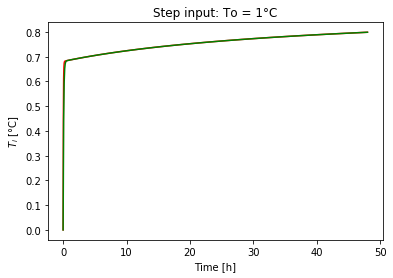

Steady-state indoor temperature obtained with:
- DAE model: 0.0200 °C
- response to step input:0.7987 °C


In [8]:
#time step

dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

# dt = 5
#dt = 360
dt=150
duration = 3600 * 24 * 2 
n = int(np.floor(duration / dt))
t = np.arange(0, n * dt, dt)

# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To Tsp Phio Phii Qaux Phia]
u = np.zeros([27, n])
u[0:10, :] = np.ones([10, n])

# u=np.ones((len(np.hstack([b[np.nonzero(b)],f[np.nonzero(f)]])),n))
# for i in range (n):
#     u[:,i]=np.hstack([b[np.nonzero(b)],f[np.nonzero(f)]])

temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T,'r', t / 3600, y_imp.T, 'g')
ax.set(xlabel='Time [h]',
        ylabel='$T_i$ [°C]',
        title='Step input: To = 1°C')
plt.show()

b = np.zeros(49)
b[[0, 5, 12, 17, 23, 24, 25, 27, 41, 47, 48]] = 1
f = np.zeros(39)


ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[6]:.4f} °C')
print(f'- response to step input:{float(y_exp[:, -2]):.4f} °C')


---

# Weather Simulation

In [9]:
#simulation with weather data

filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-01 12:00:00'
end_date = '2000-01-30 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

t = dt * np.arange(data.shape[0])

u = pd.concat([data['To'], data['To'], data['Ti'],
               α_wSW * S_c * data['Φt1'],
               τ_gSW * α_wSW * S_g * data['Φt1'],
               data['Qa'],
               α_gSW * S_g * data['Φt1']], axis=1)

temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
        
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: 'FRA_Lyon.074810_IWEC.epw'

For some reason we have not been able to complete the weather simulation part of this project, the code we used is still displayed for your information. 
